In [19]:
import numpy as np
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
import os
import matplotlib.pyplot as plt
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [3]:
train_generator=train_datagen.flow_from_directory('omr.v6i.folder/train',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 4615 images belonging to 5 classes.


In [4]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator=test_datagen.flow_from_directory('omr.v6i.folder//test',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 200 images belonging to 5 classes.


In [26]:
valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

valid_generator=valid_datagen.flow_from_directory('omr.v6i.folder//valid',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 550 images belonging to 5 classes.


In [5]:
base_model=MobileNet( weights='imagenet',include_top=False,input_shape=(224,224,3))

In [6]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x) 

preds=Dense(5,activation='softmax')(x)

In [7]:
model=Model(inputs=base_model.input,outputs=preds)
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [22]:
import tensorflow as tf 
from keras.callbacks import  EarlyStopping
Adam=tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
es = EarlyStopping(patience=5)
Adam

In [23]:
model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [24]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size

In [25]:
history=model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,
                            validation_data=test_generator,validation_steps=step_size_test,callbacks=[es],epochs=15)

d:\Anaconda3\envs\yologpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
153/153 [==============================] - 227s 1s/step - loss: 0.3387 - accuracy: 0.8822 - val_loss: 0.1321 - val_accuracy: 0.9444
Epoch 2/15
153/153 [==============================] - 186s 1s/step - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/15
153/153 [==============================] - 188s 1s/step - loss: 6.9474e-04 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/15
153/153 [==============================] - 207s 1s/step - loss: 2.8089e-04 - accuracy: 1.0000 - val_loss: 3.9503e-04 - val_accuracy: 1.0000
Epoch 5/15
153/153 [==============================] - 211s 1s/step - loss: 2.9644e-04 - accuracy: 1.0000 - val_loss: 2.8184e-04 - val_accuracy: 1.0000
Epoch 6/15
153/153 [==============================] - 218s 1s/step - loss: 2.0557e-04 - accuracy: 1.0000 - val_loss: 3.7001e-04 - val_accuracy: 1.0000
Epoch 7/15
153/153 [==============================] - 267s 2s/step - loss: 4.2539e-04 - accuracy: 1.0000 - val_los

In [28]:
score  = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

19/19 [==============================] - 9s 466ms/step - loss: 0.0080 - accuracy: 0.9982
Test loss: 0.00804946105927229
Test accuracy: 0.9981818199157715


In [29]:
predgen = model.predict_generator(valid_generator, steps=len(valid_generator), verbose=1) 
pred = np.argmax(predgen,axis = 1)
y_true=valid_generator.classes

d:\Anaconda3\envs\yologpu\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


19/19 [==============================] - 10s 485ms/step


In [30]:
model.save("MobileNet-omr.h5")

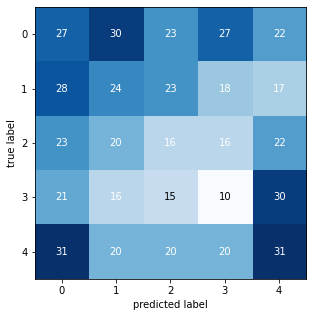

In [32]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

(1, 5)


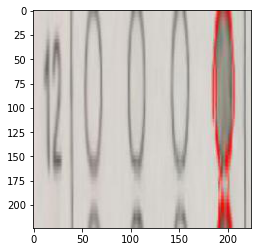

In [38]:
img_path = 'omr.v6i.folder//test//4//4th5112-jpg_11_jpg.rf.6b1d55179b94de4bd6fbcfe1c4774f4f.jpg'

#img =np.array(img_path)/255.0
img = image.load_img(img_path, target_size=(224, 224))
img = image.img_to_array(img, dtype=np.uint8)
plt.imshow(img.squeeze())
p=model.predict(img[np.newaxis, ...])
print(p.shape)